In [7]:
import numpy as np 
import pandas as pd 


In [8]:
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfTransformer
from sklearn.naive_bayes import MultinomialNB
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import GradientBoostingClassifier
import lightgbm as lgb
from sklearn.neighbors import KNeighborsClassifier
from sklearn.linear_model import Perceptron
from sklearn.linear_model import RidgeClassifier
from sklearn.ensemble import AdaBoostClassifier
from catboost import CatBoostClassifier
from sklearn.svm import SVC
from sklearn.tree import DecisionTreeClassifier

from sklearn.model_selection import train_test_split
from sklearn.model_selection import StratifiedShuffleSplit
import re
from imblearn.over_sampling import SMOTE
from sklearn.metrics import roc_auc_score 
import seaborn as sns
import matplotlib.pyplot as plt

from warnings import filterwarnings
from sklearn.model_selection import cross_validate

from sklearn.pipeline import Pipeline

In [9]:
#import dataset 
train_df = pd.read_csv("C:/Users/labiad/Downloads/train.csv")
test_df = pd.read_csv("C:/Users/labiad/Downloads/test.csv")


In [10]:
print("There are {} observations and {} features in this dataset".format(train_df.shape[0],train_df.shape[1]))

There are 6525 observations and 3 features in this dataset


In [11]:
train_df.head()

,TweetId,Label,TweetText
0,304271250237304833,Politics,'#SecKerry: The value of the @StateDept and @U...
1,304834304222064640,Politics,'@rraina1481 I fear so'
2,303568995880144898,Sports,'Watch video highlights of the #wwc13 final be...
3,304366580664528896,Sports,'RT @chelscanlan: At Nitro Circus at #AlbertPa...
4,296770931098009601,Sports,'@cricketfox Always a good thing. Thanks for t...


In [12]:
test_df.head()

,TweetId,TweetText
0,306486520121012224,'28. The home side threaten again through Maso...
1,286353402605228032,'@mrbrown @aulia Thx for asking. See http://t....
2,289531046037438464,'@Sochi2014 construction along the shores of t...
3,306451661403062273,'#SecKerry\u2019s remarks after meeting with F...
4,297941800658812928,'The #IPLauction has begun. Ricky Ponting is t...


In [13]:
train_df["TweetText"]

0       '#SecKerry: The value of the @StateDept and @U...
1                                 '@rraina1481 I fear so'
2       'Watch video highlights of the #wwc13 final be...
3       'RT @chelscanlan: At Nitro Circus at #AlbertPa...
4       '@cricketfox Always a good thing. Thanks for t...
                              ...                        
6520    'Photo: PM has laid a wreath at Martyrs Monume...
6521    'The secret of the Chennai pitch - crumbling o...
6522              @alinabhutto he isn't on Twitter either
6523    'Which England player would you take out to di...
6524    'Dmitry #Medvedev expressed condolences to the...
Name: TweetText, Length: 6525, dtype: object

In [14]:
#Text Cleaning
def cleaned(text):
    text = re.sub(r"\n","",text)
    text = text.lower()
    text = re.sub(r"\d","",text)        #Remove digits
    text = re.sub(r'[^\x00-\x7f]',r' ',text) # remove non-ascii
    text = re.sub(r'[^\w\s]','',text) #Remove punctuation
    text = re.sub(r'http\S+|www.\S+', '', text) #Remove http
    return text

train_df['cleaned'] = train_df['TweetText'].apply(lambda x : cleaned(x))

In [15]:
#Duplicated values
np.sum(train_df.duplicated())

0

In [16]:
train_df.Label.value_counts()

Sports      3325
Politics    3200
Name: Label, dtype: int64

In [17]:
#encoding feature label
cleanup_nums = {"Label":     {"Politics": 0, "Sports": 1}}
train = train_df.replace(cleanup_nums)


In [18]:
train.head()

,TweetId,Label,TweetText,cleaned
0,304271250237304833,0,'#SecKerry: The value of the @StateDept and @U...,seckerry the value of the statedept and usaid ...
1,304834304222064640,0,'@rraina1481 I fear so',rraina i fear so
2,303568995880144898,1,'Watch video highlights of the #wwc13 final be...,watch video highlights of the wwc final betwee...
3,304366580664528896,1,'RT @chelscanlan: At Nitro Circus at #AlbertPa...,rt chelscanlan at nitro circus at albertpark ...
4,296770931098009601,1,'@cricketfox Always a good thing. Thanks for t...,cricketfox always a good thing thanks for the ...


In [19]:
#missing values
np.sum(train_df.isna())

TweetId      0
Label        0
TweetText    0
cleaned      0
dtype: int64

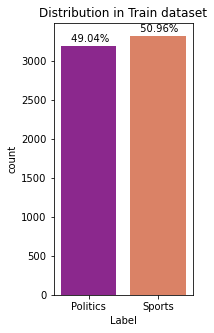

In [20]:
# data visualization 
plt.figure(figsize=(2.5,5))
plt.title("Distribution in Train dataset")
p1 = sns.countplot(x=train_df["Label"], data=train_df, palette = 'plasma')
for p in p1.patches:
        p1.annotate('{:6.2f}%'.format(p.get_height()/len(train_df)*100), (p.get_x()+0.1, p.get_height()+50))
        
plt.show()

In [21]:
#sample stratification
sss = StratifiedShuffleSplit(n_splits=1, test_size=0.2, random_state=42)

X = train['cleaned'].to_numpy()
y = train['Label'].to_numpy()
for train_index, test_index in sss.split(X, y):
    print("TRAIN:", train_index, "TEST:", test_index)
    #X_train = X.loc[train_index]
    X_train, X_test = X[train_index], X[test_index]

    y_train, y_test = y[train_index], y[test_index]

TRAIN: [2876 1388 3938 ... 5461 1325 6221] TEST: [5445 6119 5676 ... 6246 6244 3611]


In [22]:
#function pipeline
tweets_pipeline = Pipeline([('CVec', CountVectorizer(stop_words='english')),
                     ('Tfidf', TfidfTransformer())])

X_train_tranformed = tweets_pipeline.fit_transform(X_train)

X_test_tranformed = tweets_pipeline.transform(X_test)

In [23]:
#Classifiers : Supervised Machine Learning Algorithms
classifiers = {
    "Logistic Regression": LogisticRegression(class_weight='balanced'),
    "Decision Tree": DecisionTreeClassifier(class_weight='balanced'),
    "k-Nearest Neighbors": KNeighborsClassifier(),
    "Linear SVM": SVC(class_weight='balanced'),
    "Gradient Boosting Classifier": GradientBoostingClassifier(),
    "Random Forest": RandomForestClassifier(),
    'RidgeClassifier': RidgeClassifier(class_weight='balanced'),
    'AdaBoost': AdaBoostClassifier(n_estimators=100),
    'MNB': MultinomialNB(),
    'Perceptron': Perceptron(class_weight='balanced'),
    'catboost': CatBoostClassifier(verbose=0)
        
}

In [24]:
#Model Evaluation
no_classifiers = len(classifiers.keys())

from time import process_time 

#Results
def batch_classify(X_train_tranformed, y_train, X_test_tranformed, y_test, verbose = True):
    df_results = pd.DataFrame(data=np.zeros(shape=(no_classifiers,3)), columns = ['Classifier', 'Area Under Curve', 'Training time'])
    count = 0
    for key, classifier in classifiers.items():
        t_start = process_time()  
        classifier.fit(X_train_tranformed, y_train)
        t_stop = process_time() 
        t_elapsed = t_stop - t_start
        y_predicted = classifier.predict(X_test_tranformed)
        
        df_results.loc[count,'Classifier'] = key
        df_results.loc[count,'Area Under Curve'] = roc_auc_score(y_test, y_predicted)
        df_results.loc[count,'Training time'] = t_elapsed
        if verbose:
            print("trained {c} in {f:.2f} s".format(c=key, f=t_elapsed))
        count+=1

    return df_results


In [25]:

df_results = batch_classify(X_train_tranformed, y_train,X_test_tranformed, y_test)
print(df_results.sort_values(by='Area Under Curve', ascending=False))

trained Logistic Regression in 0.14 s
trained Decision Tree in 0.84 s
trained k-Nearest Neighbors in 0.00 s
trained Linear SVM in 3.72 s
trained Gradient Boosting Classifier in 2.48 s
trained Random Forest in 2.83 s
trained RidgeClassifier in 0.03 s
trained AdaBoost in 1.36 s
trained MNB in 0.00 s
trained Perceptron in 0.02 s
trained catboost in 267.52 s
                      Classifier  Area Under Curve  Training time
8                            MNB          0.954552       0.000000
6                RidgeClassifier          0.953195       0.031250
3                     Linear SVM          0.950041       3.718750
0            Logistic Regression          0.944837       0.140625
2            k-Nearest Neighbors          0.936037       0.000000
9                     Perceptron          0.932971       0.015625
5                  Random Forest          0.930510       2.828125
10                      catboost          0.921828     267.515625
1                  Decision Tree          0.86940

In [26]:

test_df['cleaned'] = test_df['TweetText'].apply(lambda x : cleaned(x))
cleanup_nums = {"Label":     {"Politics": 0, "Sports": 1}}
test = test_df.replace(cleanup_nums)

In [27]:
x = test_df['cleaned'].to_numpy()


In [28]:
x_test_tranformed = tweets_pipeline.transform(x)

In [29]:
#predictions
Classifier = MultinomialNB()
Classifier.fit(X_train_tranformed, y_train)
y_predicted = Classifier.predict(x_test_tranformed)
y_predicted




array([1, 1, 0, ..., 1, 0, 1], dtype=int64)

In [30]:
test_result = pd.Series(y_predicted, name = "Label").astype(int)
test_result

0       1
1       1
2       0
3       0
4       1
       ..
2605    1
2606    1
2607    1
2608    0
2609    1
Name: Label, Length: 2610, dtype: int32

In [31]:
#import results to a csv file
results = pd.concat([test_df["TweetId"], test_result],axis = 1)
cleanup_nums = {"Label":     {0: "Politics", 1: "Sports"}}
results = results.replace(cleanup_nums)
results.to_csv("tweet_sub.csv", index = False)